# Setup and utils

In [3]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.6 MB 4.2 MB/s eta 0:00:01


In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import json, copy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
import math
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, output_dim, depth, num_channels, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=math.floor(kernel_size/2)))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            # input_dim = (input_dim - kernel_size + 2 * math.floor(kernel_size/2)) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.AvgPool2d(2, 2))
                # input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        # flattened_size = in_channels * input_dim * input_dim
        self.calculate_to_linear_size()

        # Add one fully connected layers for classification
        self.fc = nn.Linear(self._to_linear, output_dim)

    # calculate the input dimensions to the fully-connecting layer by forwarding a dummy input
    def calculate_to_linear_size(self):
        x = torch.zeros(1, 1, 28, 28)
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break
        self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Iterate over each module in the CustomCNN class
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break

        x = x.view(-1, self._to_linear) # Flatten
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def generate_cnn(params, output_dim):
    model = CustomCNN(output_dim, params['depth'], params['width'], params['activation_function'], params['kernel_size'], params['use_pooling'])
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, lr, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, params, output_dim):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if params["freeze"]:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if params["reinit"]:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            layer.reset_parameters()
            """
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
            """

    """# if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()"""

    # reinit the final dense layer anyway
    # new_model.fc.reset_parameters()

    new_model.fc = nn.Linear(new_model._to_linear, output_dim)
    
    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

"""class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)"""

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, selected_classes):
        self.dataset = dataset
        self.label_encoder = LabelEncoder()
        
        # Fit label encoder on the selected classes
        self.label_encoder.fit(selected_classes)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        
        # Transform the label using the fitted label encoder
        label = self.label_encoder.transform([label])[0]
        
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningFashionMNIST(object):
    """
    Prepares the FashionMNIST dataset for transfer learning, dividing it into pretraining and fine-tuning datasets.

    Parameters:
    - batch_size (int): Batch size for data loaders.
    - input_dim (int): The dimensionality of the input data.
    - val_split (float): The proportion of validation data.
    - num_workers (int): Number of workers for data loaders.
    - seed (int): Seed for random operations.
    """
    def __init__(self, batch_size, params):
        self.pre_train_classes = params["pre_train_classes"]
        self.fine_tune_classes = params['fine_tune_classes']

        # we also relabel the samples for both the pretrain and the fine-tune datasets, 
        # to make sure everything is correct [0,N] -usign sklearn OrdinalEncoder to be more robust
        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return RelabeledSubset(torch.utils.data.Subset(dataset, indices), classes)

        fashion_train_data = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(fashion_train_data, params['pre_train_classes'])
        finetune_train_data = filter_dataset(fashion_train_data, params['fine_tune_classes'])

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(params['val_split'] * pretrain_len)
        finetune_val_len = int(params['val_split'] * finetune_len)
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        """# Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)"""

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        fashion_test_data = datasets.FashionMNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(fashion_test_data, params['pre_train_classes'])
        finetune_test_data = filter_dataset(fashion_test_data, params['fine_tune_classes'])

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(fashion_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

class TransferLearningWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningObj, phase):
        """
        Initializes the TransferLearningrapper object.

        Parameters:
        - transferLearningObj: An instance of the TransferLearningMNIST or TransferLearningFashionMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningObj = transferLearningObj
        # self.phase = phase
        # self.input_dim = self.transferLearningMNISTObj.input_dim
        # self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningObj.pretrain_train_loader
            self.val_loader = self.transferLearningObj.pretrain_val_loader
            self.test_loader = self.transferLearningObj.pretrain_test_loader
            self.output_dim = len(self.transferLearningObj.pre_train_classes)
        elif phase == 'finetune':
            self.train_loader = self.transferLearningObj.finetune_train_loader
            self.val_loader = self.transferLearningObj.finetune_val_loader
            self.test_loader = self.transferLearningObj.finetune_test_loader
            self.output_dim = len(self.transferLearningObj.fine_tune_classes)
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase
    
def check_class_distribution(loader, expected_classes, loader_name):
    class_counts = {label: 0 for label in expected_classes}
    for _, labels in loader:
        for label in labels:
            if label.item() in class_counts:
                class_counts[label.item()] += 1
            else:
                print(f"Unexpected class {label.item()} found in {loader_name}")
    print(f"Class distribution in {loader_name}: {class_counts}")

def test_data_loaders(tl_fashion_mnist, params):
    # Test and check data loaders
    for loader_name, loader in [
        ("Pretrain Train", tl_fashion_mnist.pretrain_train_loader),
        ("Pretrain Val", tl_fashion_mnist.pretrain_val_loader),
        ("Pretrain Test", tl_fashion_mnist.pretrain_test_loader),
        ("Finetune Train", tl_fashion_mnist.finetune_train_loader),
        ("Finetune Val", tl_fashion_mnist.finetune_val_loader),
        ("Finetune Test", tl_fashion_mnist.finetune_test_loader)
    ]:
        check_class_distribution(
            loader, 
            tl_fashion_mnist.pre_train_classes if "Pretrain" in loader_name else tl_fashion_mnist.fine_tune_classes, 
            loader_name
        )
# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# EXPERIMENT SETUP 1: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH_
- percentages_set_1 = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
- dataset: change to FashionMNIST!

- architecture:
  - Conv 1 (3,3), channels=30
  - Relu
  - _Optional AVG POOLING_
  - Conv 2 (3,3), channels=30
  - Relu
  - _Optional AVG POOLING_
  - Conv 3 (3,3), channels=30
  - Relu
  - _Optional AVG POOLING_
  - Conv 4 (3,3), channels=30
  - Relu
  - _Optional AVG POOLING_
  - Conv 5 (3,3), channels=30
  - Relu
  - _Optional AVG POOLING_
  - Dense (x, out_shape)
  - softmax

- lr pretraining = 0.001
- lr finetuning = 0.001
- lr end-to-end = 0.001

- Freezing the layers before the cut: _YES_
- Reinitializing the Convolutional layers after the cut: _YES_
- Reinitializing Dense layer: _YES_
- Pooling: _NO_


In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
#percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5]
#seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
batch_size = 4096

## Pretraining



In [4]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 5,
      'width': 30, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':batch_size,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 2, 3, 4, 6, 8],
      'fine_tune_classes': [5, 7, 9],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'percentages':percentages,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

In [5]:
dataloader = TransferLearningFashionMNIST(batch_size, params)
dataloader_wrapped = TransferLearningWrapper(dataloader, phase = 'pretrain')

In [6]:
#Create DNN model
pretrained_model = generate_cnn(params, dataloader_wrapped.output_dim)
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (fc): Linear(in_features=23520, out_features=7, bias=True)
)

In [12]:
# Train and evaluate
"""trainer = Trainer(pretrained_model, dataloader_wrapped, params["lr_pretrain"], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")"""

Epoch: 0 	Training Accuracy: 63.24%
Validation Accuracy: 62.40%
Epoch: 1 	Training Accuracy: 71.06%
Validation Accuracy: 70.43%
Epoch: 2 	Training Accuracy: 74.28%
Validation Accuracy: 73.26%
Epoch: 3 	Training Accuracy: 77.60%
Validation Accuracy: 78.07%
Epoch: 4 	Training Accuracy: 80.86%
Validation Accuracy: 80.43%
Epoch: 5 	Training Accuracy: 82.19%
Validation Accuracy: 82.05%
Epoch: 6 	Training Accuracy: 82.26%
Validation Accuracy: 82.29%
Epoch: 7 	Training Accuracy: 83.39%
Validation Accuracy: 83.24%
Epoch: 8 	Training Accuracy: 84.09%
Validation Accuracy: 83.62%
Epoch: 9 	Training Accuracy: 84.72%
Validation Accuracy: 84.14%
Epoch: 10 	Training Accuracy: 85.17%
Validation Accuracy: 84.29%
Epoch: 11 	Training Accuracy: 85.00%
Validation Accuracy: 83.88%
Epoch: 12 	Training Accuracy: 86.16%
Validation Accuracy: 85.10%
Epoch: 13 	Training Accuracy: 86.66%
Validation Accuracy: 85.74%
Epoch: 14 	Training Accuracy: 87.06%
Validation Accuracy: 85.74%
Epoch: 15 	Training Accuracy: 87.47

In [7]:
pretrained_model.load_state_dict(torch.load('pretrained_models/pretrained_0.001/pretrained_model_89percent.pth'))
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (fc): Linear(in_features=23520, out_features=7, bias=True)
)

In [8]:
eval(pretrained_model, device, dataloader_wrapped.val_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 0.3450, Accuracy: 3719.0/4200 (89%)

              precision    recall  f1-score   support

     Class 0       0.88      0.80      0.84       560
     Class 1       0.98      0.99      0.99       638
     Class 2       0.85      0.89      0.87       595
     Class 3       0.92      0.91      0.91       615
     Class 4       0.83      0.89      0.86       579
     Class 5       0.75      0.74      0.75       626
     Class 6       0.98      0.97      0.98       587

    accuracy                           0.89      4200
   macro avg       0.89      0.88      0.88      4200
weighted avg       0.89      0.89      0.89      4200



0.8854761904761905

In [14]:
# save model for later use
torch.save(pretrained_model.state_dict(), 'pretrained_models/pretrained_0.001/pretrained_model_89percent.pth')

params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
#save params as well
with open('pretrained_models/pretrained_0.001/params.json', 'w') as fp:
    json.dump(params_tmp, fp)

## Fine-tuning Experiments

In [ ]:
# load results: to continue from a checkpoint (actually don't run)
with open('results.json', 'r') as f:
    results = json.load(f)

### Baselines (skip if it was already run)

In [18]:
results = []

In [20]:
#training of baseline, end to end, models (#trials x #percentages)

dataloader_wrapped.update_phase('finetune')

# template_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                      hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

for sampled_percentage in percentages:      
    if sampled_percentage <= 0.01:
        repeats = 5
    elif sampled_percentage < 0.5:
        repeats = 3
    else:
        repeats = 1
    
    for repeat in range(repeats):
        # Print or log the sampled values for transparency
        print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

        # Reduce the dataset
        train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        torch.manual_seed(repeat)
        #train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

        # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
        params_tmp = copy.deepcopy(params)
        params_tmp["reinit"] = True
        model_new = cut_custom_cnn_model(pretrained_model, cut_point=0, params=params_tmp, output_dim=dataloader_wrapped.output_dim)
        model_new.to(device)

        # Train and evaluate
        trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
        train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
        print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

        # Store the results
        results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.8667, Test Accuracy: 0.8100

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9333, Test Accuracy: 0.7890

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9333, Test Accuracy: 0.8080

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.8667, Test Accuracy: 0.8120

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9333, Test Accuracy: 0.8063

Sampled Percentage: 0.002, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9667, Test Accuracy: 0.8487

Sampled Percentage: 0.002, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.8667, Test Accuracy: 0.8003

Sampled Percentage: 0.002, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.8667, Test Accuracy: 0.8033

Sampled Percentage: 0.0

In [21]:
# save baseline results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run.json', 'w') as f:
    json.dump(results, f)

In [8]:
#load results
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_dummy_run.json', 'r') as f:
    results_baseline = json.load(f)

# keep only the ones with cut_point = -1
results_baseline = results_baseline[1:]
results_baseline = [result for result in results_baseline if result["sampled_cut_point"] == -1]

### Fine-tuning

In [11]:
# percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
percentages = [0.5]
results = []

In [12]:
dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in percentages:

    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
        
    for sampled_cut_point in cuts:

        for repeat in range(repeats):
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, params=params, output_dim=dataloader_wrapped.output_dim)
            model_new.to(device)
            
            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.5, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9752, Test Accuracy: 0.9670

Sampled Percentage: 0.5, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9707, Test Accuracy: 0.9603

Sampled Percentage: 0.5, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9763, Test Accuracy: 0.9697

Sampled Percentage: 0.5, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9749, Test Accuracy: 0.9630

Sampled Percentage: 0.5, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Training Accuracy: 0.9825, Test Accuracy: 0.9617

Sampled Percentage: 0.5, Sampled Cut Point: 1, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9807, Test Accuracy: 0.9673

Sampled Percentage: 0.5, Sampled Cut Point: 1, Lr: 0.001, Repeat: 1
Training Accuracy: 0.9853, Test Accuracy: 0.9687

Sampled Percentage: 0.5, Sampled Cut Point: 1, Lr: 0.

In [13]:
print(results)

[{'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9751851851851852, 'test_acc': 0.967}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9707407407407408, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9762962962962963, 'test_acc': 0.9696666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9749382716049383, 'test_acc': 0.963}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.9824691358024691, 'test_acc': 0.9616666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9807407407407407, 'test_acc': 0.9673333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9853086419753087, 'test_acc': 0.9686666666666667}, {'lr': 0.001, 'sa

In [14]:
# save fine-tuning results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_0.5.json', 'w') as f:
    json.dump(results, f)
results = results[1:]

# Visualizations

In [12]:
results_baseline = [{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.8666666666666667, 'test_acc': 0.81}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9333333333333333, 'test_acc': 0.789}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9333333333333333, 'test_acc': 0.808}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.8666666666666667, 'test_acc': 0.813}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9333333333333333, 'test_acc': 0.8073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8403333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9333333333333333, 'test_acc': 0.806}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8263333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.8666666666666667, 'test_acc': 0.7873333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8286666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.9333333333333333, 'test_acc': 0.8316666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.799}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.9333333333333333, 'test_acc': 0.8036666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.802}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.8, 'test_acc': 0.7213333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9333333333333333, 'test_acc': 0.754}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.78}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.9333333333333333, 'test_acc': 0.7576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9333333333333333, 'test_acc': 0.7786666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8163333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.8666666666666667, 'test_acc': 0.822}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.7956666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.9333333333333333, 'test_acc': 0.7933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.8666666666666667, 'test_acc': 0.7886666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.753}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9666666666666667, 'test_acc': 0.8486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.8666666666666667, 'test_acc': 0.8003333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.8666666666666667, 'test_acc': 0.8033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.855}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9666666666666667, 'test_acc': 0.84}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8283333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9, 'test_acc': 0.8146666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.833}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.9, 'test_acc': 0.8206666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9666666666666667, 'test_acc': 0.827}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.9666666666666667, 'test_acc': 0.8376666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8133333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.9666666666666667, 'test_acc': 0.8306666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.85}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.7, 'test_acc': 0.8113333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.81}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.7896666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8563333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9666666666666667, 'test_acc': 0.8176666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.8, 'test_acc': 0.805}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.8333333333333334, 'test_acc': 0.7943333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.8333333333333334, 'test_acc': 0.7963333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.9333333333333333, 'test_acc': 0.82}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.8666666666666667, 'test_acc': 0.8033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.9, 'test_acc': 0.8063333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8663333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9012345679012346, 'test_acc': 0.8566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9876543209876543, 'test_acc': 0.8663333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.8888888888888888, 'test_acc': 0.8596666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9382716049382716, 'test_acc': 0.847}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.9259259259259259, 'test_acc': 0.8603333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9753086419753086, 'test_acc': 0.8556666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.9506172839506173, 'test_acc': 0.8673333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.9382716049382716, 'test_acc': 0.8466666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9753086419753086, 'test_acc': 0.8346666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.8271604938271605, 'test_acc': 0.807}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.863}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.9753086419753086, 'test_acc': 0.8563333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.9753086419753086, 'test_acc': 0.863}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.9876543209876543, 'test_acc': 0.864}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.8888888888888888, 'test_acc': 0.799}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9259259259259259, 'test_acc': 0.8613333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.9753086419753086, 'test_acc': 0.8763333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9259259259259259, 'test_acc': 0.8516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9135802469135802, 'test_acc': 0.8716666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.9506172839506173, 'test_acc': 0.851}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.8506666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.9629629629629629, 'test_acc': 0.8653333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.9506172839506173, 'test_acc': 0.859}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.9382716049382716, 'test_acc': 0.849}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.8950617283950617, 'test_acc': 0.8376666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9135802469135802, 'test_acc': 0.8653333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9567901234567902, 'test_acc': 0.8916666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9012345679012346, 'test_acc': 0.8583333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.8950617283950617, 'test_acc': 0.8666666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.9506172839506173, 'test_acc': 0.9}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9814814814814815, 'test_acc': 0.896}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.8333333333333334, 'test_acc': 0.8073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.9320987654320988, 'test_acc': 0.8666666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9197530864197531, 'test_acc': 0.8696666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.7962962962962963, 'test_acc': 0.812}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.9876543209876543, 'test_acc': 0.877}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.9135802469135802, 'test_acc': 0.8583333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.9629629629629629, 'test_acc': 0.8946666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.9938271604938271, 'test_acc': 0.866}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9691358024691358, 'test_acc': 0.8766666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9320987654320988, 'test_acc': 0.8773333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.9320987654320988, 'test_acc': 0.8656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9567901234567902, 'test_acc': 0.9063333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9567901234567902, 'test_acc': 0.8976666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.9320987654320988, 'test_acc': 0.895}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.9876543209876543, 'test_acc': 0.8796666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.9691358024691358, 'test_acc': 0.8833333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.9506172839506173, 'test_acc': 0.8886666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.9444444444444444, 'test_acc': 0.8766666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9234567901234568, 'test_acc': 0.8983333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9271604938271605, 'test_acc': 0.9146666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9271604938271605, 'test_acc': 0.916}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9135802469135802, 'test_acc': 0.894}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9271604938271605, 'test_acc': 0.9176666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.8987654320987655, 'test_acc': 0.8943333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9395061728395062, 'test_acc': 0.922}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.8098765432098766, 'test_acc': 0.8073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.9123456790123456, 'test_acc': 0.8983333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9308641975308642, 'test_acc': 0.9183333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.9419753086419753, 'test_acc': 0.9153333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.9320987654320988, 'test_acc': 0.9133333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.8641975308641975, 'test_acc': 0.883}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.9382716049382716, 'test_acc': 0.922}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.8641975308641975, 'test_acc': 0.8763333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9333333333333333, 'test_acc': 0.924}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.9256666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.9148148148148149, 'test_acc': 0.913}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9160493827160494, 'test_acc': 0.903}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9419753086419753, 'test_acc': 0.9213333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9148148148148149, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.8697530864197531, 'test_acc': 0.868}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9, 'test_acc': 0.9046666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.8925925925925926, 'test_acc': 0.9016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9141975308641975, 'test_acc': 0.9083333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.9074074074074074, 'test_acc': 0.908}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9382716049382716, 'test_acc': 0.924}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.9154320987654321, 'test_acc': 0.9156666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.9111111111111111, 'test_acc': 0.9166666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9296296296296296, 'test_acc': 0.9206666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.9345679012345679, 'test_acc': 0.9086666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.9148148148148149, 'test_acc': 0.9113333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.8888888888888888, 'test_acc': 0.8916666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.928395061728395, 'test_acc': 0.911}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.9246913580246914, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9271604938271605, 'test_acc': 0.9156666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9401234567901234, 'test_acc': 0.9266666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.924074074074074, 'test_acc': 0.9156666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9080246913580247, 'test_acc': 0.9083333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9296296296296296, 'test_acc': 0.9203333333333333}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9532921810699588, 'test_acc': 0.9456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9559670781893004, 'test_acc': 0.947}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.948559670781893, 'test_acc': 0.9453333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9473251028806584, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9516460905349794, 'test_acc': 0.9486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.9462962962962963, 'test_acc': 0.943}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9497942386831276, 'test_acc': 0.942}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.9493827160493827, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.947119341563786, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9621399176954732, 'test_acc': 0.9526666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.9602880658436214, 'test_acc': 0.9483333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.948559670781893, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.9405349794238683, 'test_acc': 0.9376666666666666}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.9510288065843622, 'test_acc': 0.9423333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.9553497942386832, 'test_acc': 0.9493333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9495884773662552, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9504115226337448, 'test_acc': 0.9456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.9409465020576132, 'test_acc': 0.9373333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9596707818930041, 'test_acc': 0.9483333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9615226337448559, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9534567901234567, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9612345679012345, 'test_acc': 0.9523333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9497530864197531, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.961604938271605, 'test_acc': 0.9516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9555555555555556, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9678240740740741, 'test_acc': 0.961}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9703703703703703, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9649691358024691, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9656635802469136, 'test_acc': 0.958}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9675154320987654, 'test_acc': 0.9596666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9670906396641146, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9682020251914053, 'test_acc': 0.962}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9720301308965177, 'test_acc': 0.9653333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9675845887873549, 'test_acc': 0.961}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9632625339590022, 'test_acc': 0.959}]

In [14]:
a = [{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.8666666666666667, 'test_acc': 0.81}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9333333333333333, 'test_acc': 0.789}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9333333333333333, 'test_acc': 0.808}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.8666666666666667, 'test_acc': 0.8123333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.9333333333333333, 'test_acc': 0.8063333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8406666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9333333333333333, 'test_acc': 0.806}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8266666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.8666666666666667, 'test_acc': 0.7876666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8286666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.9333333333333333, 'test_acc': 0.8316666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8026666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.9333333333333333, 'test_acc': 0.802}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.8, 'test_acc': 0.7213333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9333333333333333, 'test_acc': 0.754}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.78}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9333333333333333, 'test_acc': 0.7576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9333333333333333, 'test_acc': 0.7786666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.813}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.8666666666666667, 'test_acc': 0.822}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.7956666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 0.9333333333333333, 'test_acc': 0.7933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.8666666666666667, 'test_acc': 0.7886666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.754}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7803333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8126666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.767}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.8, 'test_acc': 0.8156666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.8, 'test_acc': 0.801}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8243333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.802}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9333333333333333, 'test_acc': 0.8253333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.8666666666666667, 'test_acc': 0.79}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.82}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8163333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8083333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.8666666666666667, 'test_acc': 0.8086666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8146666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.8666666666666667, 'test_acc': 0.7263333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9333333333333333, 'test_acc': 0.788}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.8666666666666667, 'test_acc': 0.7566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9333333333333333, 'test_acc': 0.752}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9333333333333333, 'test_acc': 0.7986666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.8666666666666667, 'test_acc': 0.8136666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.8666666666666667, 'test_acc': 0.8226666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.799}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.8666666666666667, 'test_acc': 0.7933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 0.8, 'test_acc': 0.7873333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7453333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7733333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9333333333333333, 'test_acc': 0.817}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9333333333333333, 'test_acc': 0.8456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9333333333333333, 'test_acc': 0.8533333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.838}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8613333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.8666666666666667, 'test_acc': 0.7656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9333333333333333, 'test_acc': 0.8473333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.8666666666666667, 'test_acc': 0.8003333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.7816666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.851}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8226666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8463333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.838}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9333333333333333, 'test_acc': 0.7403333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9333333333333333, 'test_acc': 0.787}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.822}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9333333333333333, 'test_acc': 0.7206666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7746666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.8666666666666667, 'test_acc': 0.8296666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8276666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.809}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 0.9333333333333333, 'test_acc': 0.86}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7423333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.824}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9333333333333333, 'test_acc': 0.8573333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8236666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9333333333333333, 'test_acc': 0.854}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8833333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8646666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.719}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8426666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9333333333333333, 'test_acc': 0.8013333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8176666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.816}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.9333333333333333, 'test_acc': 0.8236666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8496666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8183333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9333333333333333, 'test_acc': 0.706}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.8666666666666667, 'test_acc': 0.83}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.7653333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.7756666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.81}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.81}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.7936666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8283333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8256666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8956666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7676666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7563333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8143333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8113333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8063333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.73}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.7953333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.7896666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.753}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7913333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.7883333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.7583333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7306666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.6816666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.9333333333333333, 'test_acc': 0.8146666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.779}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.7363333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7266666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7766666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8396666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7806666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.816}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.756}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.778}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9333333333333333, 'test_acc': 0.728}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.831}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9333333333333333, 'test_acc': 0.8043333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8386666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.778}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.7256666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.82}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.79}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.766}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7903333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8036666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.724}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7166666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.6753333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.813}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.7646666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.6626666666666666}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7323333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.753}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.778}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7543333333333333}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8166666666666667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6946666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9666666666666667, 'test_acc': 0.848}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.8666666666666667, 'test_acc': 0.8003333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.8666666666666667, 'test_acc': 0.8033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8563333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8386666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8283333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9, 'test_acc': 0.8146666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8326666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9, 'test_acc': 0.821}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.9666666666666667, 'test_acc': 0.827}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.9666666666666667, 'test_acc': 0.8373333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8133333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.9666666666666667, 'test_acc': 0.8323333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.7, 'test_acc': 0.8113333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.81}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9333333333333333, 'test_acc': 0.7896666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9666666666666667, 'test_acc': 0.8176666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.8666666666666667, 'test_acc': 0.8016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.8333333333333334, 'test_acc': 0.7943333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 0.8333333333333334, 'test_acc': 0.7956666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 0.9333333333333333, 'test_acc': 0.8193333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.8666666666666667, 'test_acc': 0.8033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 0.9, 'test_acc': 0.8063333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8643333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.8666666666666667, 'test_acc': 0.7943333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9, 'test_acc': 0.8}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9, 'test_acc': 0.8616666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.846}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8116666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9333333333333333, 'test_acc': 0.8243333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8336666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.8666666666666667, 'test_acc': 0.8316666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.831}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.8666666666666667, 'test_acc': 0.8346666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8346666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.844}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8376666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9, 'test_acc': 0.8316666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8173333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.8333333333333334, 'test_acc': 0.783}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8496666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9666666666666667, 'test_acc': 0.821}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.8, 'test_acc': 0.8143333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.8333333333333334, 'test_acc': 0.8073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 0.9333333333333333, 'test_acc': 0.8283333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.9, 'test_acc': 0.8103333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 0.9333333333333333, 'test_acc': 0.8093333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.9, 'test_acc': 0.8036666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9666666666666667, 'test_acc': 0.855}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9, 'test_acc': 0.8196666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9, 'test_acc': 0.8363333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8833333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9666666666666667, 'test_acc': 0.8543333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.9333333333333333, 'test_acc': 0.8523333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.841}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9666666666666667, 'test_acc': 0.8583333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9666666666666667, 'test_acc': 0.8273333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.848}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9666666666666667, 'test_acc': 0.8643333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.8333333333333334, 'test_acc': 0.832}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.9666666666666667, 'test_acc': 0.856}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8723333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9333333333333333, 'test_acc': 0.865}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8596666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.867}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9333333333333333, 'test_acc': 0.8006666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8356666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.8, 'test_acc': 0.8436666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.8666666666666667, 'test_acc': 0.8133333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 0.9, 'test_acc': 0.8346666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.865}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 0.9333333333333333, 'test_acc': 0.7933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8683333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9, 'test_acc': 0.8663333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9666666666666667, 'test_acc': 0.8546666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8926666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8683333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.858}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.872}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.884}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9, 'test_acc': 0.82}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.9666666666666667, 'test_acc': 0.866}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9333333333333333, 'test_acc': 0.8826666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.9666666666666667, 'test_acc': 0.8683333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8703333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8766666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9333333333333333, 'test_acc': 0.8906666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8923333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.812}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.828}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8683333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8316666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 0.9666666666666667, 'test_acc': 0.7896666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8483333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.852}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8893333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8736666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8723333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8086666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.834}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.85}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.819}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.844}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8513333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.833}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8413333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8896666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.9333333333333333, 'test_acc': 0.8156666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8093333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.836}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.9666666666666667, 'test_acc': 0.868}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8946666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9666666666666667, 'test_acc': 0.7773333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8646666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9666666666666667, 'test_acc': 0.8556666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.9333333333333333, 'test_acc': 0.76}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.782}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 0.9333333333333333, 'test_acc': 0.8516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.871}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8636666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8803333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.864}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9666666666666667, 'test_acc': 0.8403333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8703333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8533333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8213333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.864}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.9666666666666667, 'test_acc': 0.7743333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8536666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8743333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8386666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8266666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8523333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.9666666666666667, 'test_acc': 0.8693333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9666666666666667, 'test_acc': 0.7696666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9666666666666667, 'test_acc': 0.7866666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8276666666666667}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.8, 'test_acc': 0.7796666666666666}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7993333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.782}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.799}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8313333333333334}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8673333333333333}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.844}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8666666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9012345679012346, 'test_acc': 0.857}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9876543209876543, 'test_acc': 0.866}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9012345679012346, 'test_acc': 0.8596666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.9382716049382716, 'test_acc': 0.848}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9259259259259259, 'test_acc': 0.8603333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9753086419753086, 'test_acc': 0.8556666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9506172839506173, 'test_acc': 0.8673333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9382716049382716, 'test_acc': 0.8456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.9753086419753086, 'test_acc': 0.8346666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.8271604938271605, 'test_acc': 0.807}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8606666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.9876543209876543, 'test_acc': 0.87}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.9876543209876543, 'test_acc': 0.864}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.8888888888888888, 'test_acc': 0.799}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9259259259259259, 'test_acc': 0.8616666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9753086419753086, 'test_acc': 0.8766666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9259259259259259, 'test_acc': 0.8513333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.8271604938271605, 'test_acc': 0.8606666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.9506172839506173, 'test_acc': 0.8526666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.8503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 0.9629629629629629, 'test_acc': 0.8656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.9506172839506173, 'test_acc': 0.8593333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 0.9382716049382716, 'test_acc': 0.849}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.8641975308641975, 'test_acc': 0.8343333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9012345679012346, 'test_acc': 0.8476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9876543209876543, 'test_acc': 0.8656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9135802469135802, 'test_acc': 0.8673333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9629629629629629, 'test_acc': 0.8443333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.9629629629629629, 'test_acc': 0.8416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9629629629629629, 'test_acc': 0.8633333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9506172839506173, 'test_acc': 0.8566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9135802469135802, 'test_acc': 0.8466666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8236666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9382716049382716, 'test_acc': 0.8706666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.9506172839506173, 'test_acc': 0.8753333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9259259259259259, 'test_acc': 0.845}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.9629629629629629, 'test_acc': 0.8776666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9876543209876543, 'test_acc': 0.8593333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.8888888888888888, 'test_acc': 0.8113333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9506172839506173, 'test_acc': 0.8573333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9629629629629629, 'test_acc': 0.8736666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9506172839506173, 'test_acc': 0.8776666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.8888888888888888, 'test_acc': 0.875}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.9382716049382716, 'test_acc': 0.872}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 0.9753086419753086, 'test_acc': 0.8553333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.9506172839506173, 'test_acc': 0.872}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 0.9506172839506173, 'test_acc': 0.8606666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.9382716049382716, 'test_acc': 0.844}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9506172839506173, 'test_acc': 0.88}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9259259259259259, 'test_acc': 0.8713333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9753086419753086, 'test_acc': 0.8976666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.8641975308641975, 'test_acc': 0.8443333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9629629629629629, 'test_acc': 0.88}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.8641975308641975, 'test_acc': 0.854}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9876543209876543, 'test_acc': 0.8686666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9259259259259259, 'test_acc': 0.8546666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9135802469135802, 'test_acc': 0.8613333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.9753086419753086, 'test_acc': 0.86}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9876543209876543, 'test_acc': 0.875}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.8888888888888888, 'test_acc': 0.856}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.9259259259259259, 'test_acc': 0.8696666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.8641975308641975, 'test_acc': 0.8593333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.8765432098765432, 'test_acc': 0.8563333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9259259259259259, 'test_acc': 0.838}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9506172839506173, 'test_acc': 0.8903333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9876543209876543, 'test_acc': 0.8923333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.9876543209876543, 'test_acc': 0.9006666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9259259259259259, 'test_acc': 0.9016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.8518518518518519, 'test_acc': 0.8523333333333334}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.8563333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.9036666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 0.9629629629629629, 'test_acc': 0.8916666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9876543209876543, 'test_acc': 0.9023333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9506172839506173, 'test_acc': 0.891}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9026666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8953333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.91}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9113333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.9876543209876543, 'test_acc': 0.8913333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.907}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.8641975308641975, 'test_acc': 0.8753333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8943333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9753086419753086, 'test_acc': 0.903}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.9012345679012346, 'test_acc': 0.9026666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9876543209876543, 'test_acc': 0.8883333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.9876543209876543, 'test_acc': 0.9003333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9012345679012346, 'test_acc': 0.881}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9629629629629629, 'test_acc': 0.871}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.908}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8973333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.9876543209876543, 'test_acc': 0.9096666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.9506172839506173, 'test_acc': 0.916}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 0.9629629629629629, 'test_acc': 0.9033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.8603333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 0.9629629629629629, 'test_acc': 0.9083333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 0.9259259259259259, 'test_acc': 0.902}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9146666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9876543209876543, 'test_acc': 0.8953333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9629629629629629, 'test_acc': 0.881}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8983333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9876543209876543, 'test_acc': 0.8753333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.912}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.9876543209876543, 'test_acc': 0.8993333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.899}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8976666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.9629629629629629, 'test_acc': 0.8863333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9063333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.9876543209876543, 'test_acc': 0.9056666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.9382716049382716, 'test_acc': 0.889}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8866666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.9259259259259259, 'test_acc': 0.8823333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.9629629629629629, 'test_acc': 0.8766666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.9876543209876543, 'test_acc': 0.8923333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9876543209876543, 'test_acc': 0.91}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.896}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9876543209876543, 'test_acc': 0.913}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.9753086419753086, 'test_acc': 0.902}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 0.9629629629629629, 'test_acc': 0.9036666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 0.9629629629629629, 'test_acc': 0.8663333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 0.9629629629629629, 'test_acc': 0.8946666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.895}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9213333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.893}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8843333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9876543209876543, 'test_acc': 0.8876666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9103333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9003333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.9876543209876543, 'test_acc': 0.89}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.9382716049382716, 'test_acc': 0.8746666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9076666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.9876543209876543, 'test_acc': 0.9166666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.9876543209876543, 'test_acc': 0.8816666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8946666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.9753086419753086, 'test_acc': 0.899}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.9629629629629629, 'test_acc': 0.8766666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9629629629629629, 'test_acc': 0.8706666666666667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9629629629629629, 'test_acc': 0.8883333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.894}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.9876543209876543, 'test_acc': 0.918}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.9876543209876543, 'test_acc': 0.921}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 0.9876543209876543, 'test_acc': 0.906}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.875}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.9113333333333333}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.9166666666666666}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9163333333333333}]
b = [{'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.8950617283950617, 'test_acc': 0.8376666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9197530864197531, 'test_acc': 0.861}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9567901234567902, 'test_acc': 0.89}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9012345679012346, 'test_acc': 0.8576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.8950617283950617, 'test_acc': 0.867}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9691358024691358, 'test_acc': 0.8976666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9814814814814815, 'test_acc': 0.896}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.8333333333333334, 'test_acc': 0.8073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9259259259259259, 'test_acc': 0.865}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.9197530864197531, 'test_acc': 0.8696666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.7962962962962963, 'test_acc': 0.812}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9814814814814815, 'test_acc': 0.8793333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.9135802469135802, 'test_acc': 0.8586666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.9629629629629629, 'test_acc': 0.897}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.9691358024691358, 'test_acc': 0.878}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.8827160493827161, 'test_acc': 0.8643333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9320987654320988, 'test_acc': 0.8773333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9691358024691358, 'test_acc': 0.8853333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9567901234567902, 'test_acc': 0.9066666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.9567901234567902, 'test_acc': 0.8976666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.9444444444444444, 'test_acc': 0.894}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 0.9876543209876543, 'test_acc': 0.8796666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 0.9938271604938271, 'test_acc': 0.879}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.9506172839506173, 'test_acc': 0.8883333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 0.9444444444444444, 'test_acc': 0.877}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9444444444444444, 'test_acc': 0.8673333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9197530864197531, 'test_acc': 0.8576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9012345679012346, 'test_acc': 0.861}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8943333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9876543209876543, 'test_acc': 0.8903333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.9444444444444444, 'test_acc': 0.89}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9444444444444444, 'test_acc': 0.881}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.8827160493827161, 'test_acc': 0.8513333333333334}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9074074074074074, 'test_acc': 0.827}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.9567901234567902, 'test_acc': 0.8803333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9691358024691358, 'test_acc': 0.883}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.9814814814814815, 'test_acc': 0.8933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9197530864197531, 'test_acc': 0.873}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.9444444444444444, 'test_acc': 0.8953333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9876543209876543, 'test_acc': 0.8746666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9506172839506173, 'test_acc': 0.8656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9506172839506173, 'test_acc': 0.8883333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.8580246913580247, 'test_acc': 0.825}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9938271604938271, 'test_acc': 0.8996666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.9691358024691358, 'test_acc': 0.909}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.9320987654320988, 'test_acc': 0.9033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 0.9197530864197531, 'test_acc': 0.88}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.9567901234567902, 'test_acc': 0.8843333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 0.9320987654320988, 'test_acc': 0.8796666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.9506172839506173, 'test_acc': 0.867}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9012345679012346, 'test_acc': 0.8573333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.8518518518518519, 'test_acc': 0.8506666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9629629629629629, 'test_acc': 0.901}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9753086419753086, 'test_acc': 0.908}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9006666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.915}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9876543209876543, 'test_acc': 0.9126666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.8395061728395061, 'test_acc': 0.847}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.8765432098765432, 'test_acc': 0.8816666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.9876543209876543, 'test_acc': 0.9016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9259259259259259, 'test_acc': 0.887}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9938271604938271, 'test_acc': 0.9066666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.8271604938271605, 'test_acc': 0.8546666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.9012345679012346, 'test_acc': 0.876}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.845679012345679, 'test_acc': 0.867}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9629629629629629, 'test_acc': 0.906}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9444444444444444, 'test_acc': 0.895}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.8580246913580247, 'test_acc': 0.8466666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.8333333333333334, 'test_acc': 0.865}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9753086419753086, 'test_acc': 0.9303333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.9876543209876543, 'test_acc': 0.922}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.8906666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 0.9814814814814815, 'test_acc': 0.9076666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 0.9691358024691358, 'test_acc': 0.9106666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 0.9938271604938271, 'test_acc': 0.902}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9814814814814815, 'test_acc': 0.9056666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.8888888888888888, 'test_acc': 0.9053333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9938271604938271, 'test_acc': 0.9183333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9938271604938271, 'test_acc': 0.9116666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9629629629629629, 'test_acc': 0.9166666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.9753086419753086, 'test_acc': 0.9136666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.9938271604938271, 'test_acc': 0.917}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9506172839506173, 'test_acc': 0.913}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9135802469135802, 'test_acc': 0.899}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9116666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9814814814814815, 'test_acc': 0.925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.916}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9876543209876543, 'test_acc': 0.9166666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.9938271604938271, 'test_acc': 0.9173333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.8888888888888888, 'test_acc': 0.8813333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9876543209876543, 'test_acc': 0.9003333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.9938271604938271, 'test_acc': 0.9216666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.8827160493827161, 'test_acc': 0.8966666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.9814814814814815, 'test_acc': 0.9296666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 0.9876543209876543, 'test_acc': 0.9206666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 0.9629629629629629, 'test_acc': 0.8973333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 0.9938271604938271, 'test_acc': 0.924}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 0.9382716049382716, 'test_acc': 0.9133333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 0.9938271604938271, 'test_acc': 0.921}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9876543209876543, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9506172839506173, 'test_acc': 0.899}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9506172839506173, 'test_acc': 0.9126666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9016666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9876543209876543, 'test_acc': 0.9266666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.9938271604938271, 'test_acc': 0.9176666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.9814814814814815, 'test_acc': 0.9206666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 0.9938271604938271, 'test_acc': 0.9196666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.9691358024691358, 'test_acc': 0.908}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.9814814814814815, 'test_acc': 0.9253333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.9814814814814815, 'test_acc': 0.9183333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 0.9691358024691358, 'test_acc': 0.9103333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.9938271604938271, 'test_acc': 0.911}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.9814814814814815, 'test_acc': 0.8996666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.9444444444444444, 'test_acc': 0.9086666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9444444444444444, 'test_acc': 0.9083333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 0.9629629629629629, 'test_acc': 0.897}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9691358024691358, 'test_acc': 0.9193333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.9938271604938271, 'test_acc': 0.9236666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 0.9753086419753086, 'test_acc': 0.9263333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 0.9753086419753086, 'test_acc': 0.914}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 0.9876543209876543, 'test_acc': 0.9166666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 0.9938271604938271, 'test_acc': 0.9196666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.918}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.9629629629629629, 'test_acc': 0.9056666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9320987654320988, 'test_acc': 0.9163333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9629629629629629, 'test_acc': 0.9243333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.914}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9938271604938271, 'test_acc': 0.9283333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 0.9814814814814815, 'test_acc': 0.9256666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 0.9753086419753086, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.9691358024691358, 'test_acc': 0.92}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.9691358024691358, 'test_acc': 0.9136666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9163333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.9814814814814815, 'test_acc': 0.928}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.9876543209876543, 'test_acc': 0.916}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9263333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.9753086419753086, 'test_acc': 0.907}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.9876543209876543, 'test_acc': 0.9076666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9086666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9444444444444444, 'test_acc': 0.9}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.9506172839506173, 'test_acc': 0.8936666666666667}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.9567901234567902, 'test_acc': 0.914}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.9876543209876543, 'test_acc': 0.9336666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 0.9876543209876543, 'test_acc': 0.9246666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 0.9506172839506173, 'test_acc': 0.8843333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 0.9876543209876543, 'test_acc': 0.9236666666666666}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 0.9938271604938271, 'test_acc': 0.9263333333333333}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9243333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9259259259259259, 'test_acc': 0.8976666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9259259259259259, 'test_acc': 0.9116666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9012345679012346, 'test_acc': 0.8996666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9135802469135802, 'test_acc': 0.8953333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.928395061728395, 'test_acc': 0.9173333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9098765432098765, 'test_acc': 0.8986666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9320987654320988, 'test_acc': 0.9176666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.8098765432098766, 'test_acc': 0.8073333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9148148148148149, 'test_acc': 0.9046666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.937037037037037, 'test_acc': 0.9213333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.9444444444444444, 'test_acc': 0.9173333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9481481481481482, 'test_acc': 0.916}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.8641975308641975, 'test_acc': 0.8833333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.937037037037037, 'test_acc': 0.9173333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.8641975308641975, 'test_acc': 0.876}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9345679012345679, 'test_acc': 0.9243333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9345679012345679, 'test_acc': 0.9263333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9222222222222223, 'test_acc': 0.9186666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9160493827160494, 'test_acc': 0.9033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.9395061728395062, 'test_acc': 0.9213333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9358024691358025, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9296296296296296, 'test_acc': 0.9096666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9506172839506173, 'test_acc': 0.9216666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9345679012345679, 'test_acc': 0.9093333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9666666666666667, 'test_acc': 0.93}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.9432098765432099, 'test_acc': 0.9133333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9308641975308642, 'test_acc': 0.92}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.928395061728395, 'test_acc': 0.9193333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.891358024691358, 'test_acc': 0.8823333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.937037037037037, 'test_acc': 0.924}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9419753086419753, 'test_acc': 0.9153333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.9419753086419753, 'test_acc': 0.9203333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9209876543209876, 'test_acc': 0.9103333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.9135802469135802, 'test_acc': 0.8933333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9345679012345679, 'test_acc': 0.908}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9308641975308642, 'test_acc': 0.9113333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9345679012345679, 'test_acc': 0.9193333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9382716049382716, 'test_acc': 0.9266666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9382716049382716, 'test_acc': 0.9193333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.9197530864197531, 'test_acc': 0.9123333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.8679012345679012, 'test_acc': 0.8523333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9481481481481482, 'test_acc': 0.9256666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9481481481481482, 'test_acc': 0.9303333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9654320987654321, 'test_acc': 0.9313333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9580246913580247, 'test_acc': 0.9306666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.9592592592592593, 'test_acc': 0.927}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9604938271604938, 'test_acc': 0.931}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.8444444444444444, 'test_acc': 0.8496666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9518518518518518, 'test_acc': 0.9356666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.8703703703703703, 'test_acc': 0.8776666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9592592592592593, 'test_acc': 0.9316666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9469135802469136, 'test_acc': 0.9246666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.9444444444444444, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.9666666666666667, 'test_acc': 0.9373333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9567901234567902, 'test_acc': 0.9336666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9592592592592593, 'test_acc': 0.9356666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9444444444444444, 'test_acc': 0.929}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9592592592592593, 'test_acc': 0.9333333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.9444444444444444, 'test_acc': 0.9283333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9641975308641976, 'test_acc': 0.9333333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.980246913580247, 'test_acc': 0.9426666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9592592592592593, 'test_acc': 0.9406666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9703703703703703, 'test_acc': 0.9403333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9679012345679012, 'test_acc': 0.9343333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9790123456790123, 'test_acc': 0.9383333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.971604938271605, 'test_acc': 0.939}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.9777777777777777, 'test_acc': 0.938}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9567901234567902, 'test_acc': 0.9383333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9814814814814815, 'test_acc': 0.9423333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.9679012345679012, 'test_acc': 0.942}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9876543209876543, 'test_acc': 0.9433333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.9814814814814815, 'test_acc': 0.9396666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9506172839506173, 'test_acc': 0.9443333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.980246913580247, 'test_acc': 0.9406666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9728395061728395, 'test_acc': 0.9423333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9580246913580247, 'test_acc': 0.9426666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.9530864197530864, 'test_acc': 0.9406666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.9814814814814815, 'test_acc': 0.9433333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.8814814814814815, 'test_acc': 0.8956666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.9753086419753086, 'test_acc': 0.9413333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9753086419753086, 'test_acc': 0.941}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9506172839506173, 'test_acc': 0.9326666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9851851851851852, 'test_acc': 0.941}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9938271604938271, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9617283950617284, 'test_acc': 0.931}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.9839506172839506, 'test_acc': 0.9366666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.980246913580247, 'test_acc': 0.9393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 0.9765432098765432, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.9814814814814815, 'test_acc': 0.9413333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 0.9790123456790123, 'test_acc': 0.9463333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.9703703703703703, 'test_acc': 0.932}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.9888888888888889, 'test_acc': 0.937}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 0.9753086419753086, 'test_acc': 0.9436666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.9814814814814815, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.9592592592592593, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.991358024691358, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9592592592592593, 'test_acc': 0.931}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 0.9728395061728395, 'test_acc': 0.937}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9444444444444444, 'test_acc': 0.928}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.9851851851851852, 'test_acc': 0.9396666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.9580246913580247, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9592592592592593, 'test_acc': 0.9343333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9555555555555556, 'test_acc': 0.938}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9641975308641976, 'test_acc': 0.9356666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9432098765432099, 'test_acc': 0.932}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 0.9444444444444444, 'test_acc': 0.9313333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 0.9679012345679012, 'test_acc': 0.9353333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.9790123456790123, 'test_acc': 0.9393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.9654320987654321, 'test_acc': 0.9373333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 0.9555555555555556, 'test_acc': 0.942}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.9814814814814815, 'test_acc': 0.935}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.971604938271605, 'test_acc': 0.9363333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.9864197530864197, 'test_acc': 0.9406666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.9851851851851852, 'test_acc': 0.9363333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.9740740740740741, 'test_acc': 0.9433333333333334}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9938271604938271, 'test_acc': 0.9466666666666667}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9592592592592593, 'test_acc': 0.9333333333333333}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.945679012345679, 'test_acc': 0.9316666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.9555555555555556, 'test_acc': 0.9346666666666666}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.9950617283950617, 'test_acc': 0.9473333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9148148148148149, 'test_acc': 0.9136666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.8629629629629629, 'test_acc': 0.8623333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.8987654320987655, 'test_acc': 0.9046666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.8932098765432098, 'test_acc': 0.901}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.917283950617284, 'test_acc': 0.9103333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9080246913580247, 'test_acc': 0.9103333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9382716049382716, 'test_acc': 0.924}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9160493827160494, 'test_acc': 0.9133333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9117283950617284, 'test_acc': 0.9176666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.9104938271604939, 'test_acc': 0.9096666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.9314814814814815, 'test_acc': 0.9033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9148148148148149, 'test_acc': 0.9113333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.8820987654320988, 'test_acc': 0.8913333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.9296296296296296, 'test_acc': 0.9113333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.9259259259259259, 'test_acc': 0.9153333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9277777777777778, 'test_acc': 0.919}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9395061728395062, 'test_acc': 0.9263333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9228395061728395, 'test_acc': 0.9156666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.908641975308642, 'test_acc': 0.909}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.9308641975308642, 'test_acc': 0.9196666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9141975308641975, 'test_acc': 0.9173333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9049382716049382, 'test_acc': 0.9033333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9203703703703704, 'test_acc': 0.9213333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9271604938271605, 'test_acc': 0.921}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9234567901234568, 'test_acc': 0.9153333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.9302469135802469, 'test_acc': 0.919}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.8975308641975308, 'test_acc': 0.8853333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9253086419753086, 'test_acc': 0.9233333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.8765432098765432, 'test_acc': 0.8786666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.9339506172839506, 'test_acc': 0.924}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9382716049382716, 'test_acc': 0.917}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.9382716049382716, 'test_acc': 0.928}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9253086419753086, 'test_acc': 0.9226666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.937037037037037, 'test_acc': 0.9276666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9419753086419753, 'test_acc': 0.927}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9290123456790124, 'test_acc': 0.9216666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.921604938271605, 'test_acc': 0.9196666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9290123456790124, 'test_acc': 0.9213333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9481481481481482, 'test_acc': 0.931}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.9166666666666666, 'test_acc': 0.9143333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9444444444444444, 'test_acc': 0.9273333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9358024691358025, 'test_acc': 0.9303333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9432098765432099, 'test_acc': 0.9356666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.8364197530864198, 'test_acc': 0.847}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9549382716049383, 'test_acc': 0.939}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.9487654320987654, 'test_acc': 0.9353333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9512345679012346, 'test_acc': 0.935}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9351851851851852, 'test_acc': 0.93}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9481481481481482, 'test_acc': 0.9396666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.8722222222222222, 'test_acc': 0.8816666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9506172839506173, 'test_acc': 0.9296666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9401234567901234, 'test_acc': 0.9273333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.9450617283950618, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.9512345679012346, 'test_acc': 0.94}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9592592592592593, 'test_acc': 0.938}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.95, 'test_acc': 0.9366666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9438271604938272, 'test_acc': 0.928}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9506172839506173, 'test_acc': 0.9366666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.95, 'test_acc': 0.936}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9432098765432099, 'test_acc': 0.9346666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9691358024691358, 'test_acc': 0.9443333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9641975308641976, 'test_acc': 0.9453333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9611111111111111, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9691358024691358, 'test_acc': 0.9453333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9617283950617284, 'test_acc': 0.936}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.9598765432098766, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.9635802469135802, 'test_acc': 0.944}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9567901234567902, 'test_acc': 0.95}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9740740740740741, 'test_acc': 0.9456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.9592592592592593, 'test_acc': 0.947}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9740740740740741, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.9753086419753086, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9543209876543209, 'test_acc': 0.9486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.9586419753086419, 'test_acc': 0.9393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.8907407407407407, 'test_acc': 0.9}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9574074074074074, 'test_acc': 0.945}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.9654320987654321, 'test_acc': 0.9406666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.9524691358024692, 'test_acc': 0.94}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.9660493827160493, 'test_acc': 0.9453333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.967283950617284, 'test_acc': 0.9436666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.945679012345679, 'test_acc': 0.9396666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9401234567901234, 'test_acc': 0.9313333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9604938271604938, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.975925925925926, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9567901234567902, 'test_acc': 0.94}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.9308641975308642, 'test_acc': 0.932}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.9654320987654321, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 0.971604938271605, 'test_acc': 0.9513333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.9783950617283951, 'test_acc': 0.9486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 0.9796296296296296, 'test_acc': 0.949}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.9629629629629629, 'test_acc': 0.9356666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.9808641975308642, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 0.9407407407407408, 'test_acc': 0.9376666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.9641975308641976, 'test_acc': 0.9426666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.971604938271605, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.9648148148148148, 'test_acc': 0.9413333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9487654320987654, 'test_acc': 0.932}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 0.9574074074074074, 'test_acc': 0.9343333333333333}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9709876543209877, 'test_acc': 0.944}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.9654320987654321, 'test_acc': 0.9453333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.9820987654320987, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9820987654320987, 'test_acc': 0.952}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9549382716049383, 'test_acc': 0.9393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.95, 'test_acc': 0.9393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9617283950617284, 'test_acc': 0.9423333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 0.9592592592592593, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 0.9808641975308642, 'test_acc': 0.9473333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.9592592592592593, 'test_acc': 0.9423333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.980246913580247, 'test_acc': 0.9516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 0.9691358024691358, 'test_acc': 0.94}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.9814814814814815, 'test_acc': 0.947}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.9790123456790123, 'test_acc': 0.9426666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.971604938271605, 'test_acc': 0.9506666666666667}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.9524691358024692, 'test_acc': 0.9403333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.9858024691358025, 'test_acc': 0.9493333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9598765432098766, 'test_acc': 0.939}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9820987654320987, 'test_acc': 0.9483333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.9314814814814815, 'test_acc': 0.932}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.9611111111111111, 'test_acc': 0.9423333333333334}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.9765432098765432, 'test_acc': 0.9506666666666667}]
c = [{'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9524691358024692, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9458847736625514, 'test_acc': 0.9413333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9452674897119342, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9530864197530864, 'test_acc': 0.9463333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.951440329218107, 'test_acc': 0.944}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9493827160493827, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9497942386831276, 'test_acc': 0.942}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9508230452674897, 'test_acc': 0.9453333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9534979423868313, 'test_acc': 0.9433333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.9627572016460906, 'test_acc': 0.952}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.9613168724279836, 'test_acc': 0.9473333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9487654320987654, 'test_acc': 0.943}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.9390946502057613, 'test_acc': 0.9393333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.951440329218107, 'test_acc': 0.9416666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.9543209876543209, 'test_acc': 0.9483333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9491769547325103, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9475308641975309, 'test_acc': 0.9403333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9395061728395062, 'test_acc': 0.9353333333333333}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9578189300411523, 'test_acc': 0.9463333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.9615226337448559, 'test_acc': 0.95}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9606995884773663, 'test_acc': 0.9506666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9541152263374486, 'test_acc': 0.9456666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9432098765432099, 'test_acc': 0.947}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9563786008230453, 'test_acc': 0.9466666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9584362139917696, 'test_acc': 0.949}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.9572016460905349, 'test_acc': 0.9486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9547325102880658, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9576131687242798, 'test_acc': 0.9516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9487654320987654, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.9572016460905349, 'test_acc': 0.952}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9567901234567902, 'test_acc': 0.9473333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.9541152263374486, 'test_acc': 0.9483333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9522633744855967, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.951440329218107, 'test_acc': 0.9443333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9569958847736626, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9590534979423868, 'test_acc': 0.947}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9557613168724279, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9532921810699588, 'test_acc': 0.9493333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.9609053497942387, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.9574074074074074, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9454732510288066, 'test_acc': 0.9386666666666666}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9557613168724279, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9541152263374486, 'test_acc': 0.9476666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9629629629629629, 'test_acc': 0.9553333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9543209876543209, 'test_acc': 0.9443333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.9582304526748971, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9609053497942387, 'test_acc': 0.953}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9600823045267489, 'test_acc': 0.949}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9660493827160493, 'test_acc': 0.9576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.9625514403292181, 'test_acc': 0.9546666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9611111111111111, 'test_acc': 0.95}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9674897119341563, 'test_acc': 0.9543333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.9676954732510288, 'test_acc': 0.9626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.9567901234567902, 'test_acc': 0.948}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9676954732510288, 'test_acc': 0.958}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9685185185185186, 'test_acc': 0.9546666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9625514403292181, 'test_acc': 0.95}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9681069958847737, 'test_acc': 0.9563333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.9555555555555556, 'test_acc': 0.9473333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9697530864197531, 'test_acc': 0.958}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9676954732510288, 'test_acc': 0.9576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9534979423868313, 'test_acc': 0.9486666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9621399176954732, 'test_acc': 0.9543333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9707818930041152, 'test_acc': 0.9593333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9664609053497942, 'test_acc': 0.955}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.9654320987654321, 'test_acc': 0.951}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.948559670781893, 'test_acc': 0.9446666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9734567901234568, 'test_acc': 0.9626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9699588477366256, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.9574074074074074, 'test_acc': 0.948}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.974485596707819, 'test_acc': 0.9613333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.9732510288065843, 'test_acc': 0.9586666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9668724279835391, 'test_acc': 0.9606666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.9621399176954732, 'test_acc': 0.9496666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9685185185185186, 'test_acc': 0.9566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9767489711934156, 'test_acc': 0.9626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.9765432098765432, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.9732510288065843, 'test_acc': 0.9616666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.9693415637860082, 'test_acc': 0.9543333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.9633744855967078, 'test_acc': 0.9516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.97880658436214, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9806584362139917, 'test_acc': 0.958}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9648148148148148, 'test_acc': 0.956}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9767489711934156, 'test_acc': 0.956}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.975925925925926, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.9613168724279836, 'test_acc': 0.9496666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.9722222222222222, 'test_acc': 0.9586666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 0.9695473251028807, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.9724279835390947, 'test_acc': 0.9576666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 0.97880658436214, 'test_acc': 0.9613333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.9767489711934156, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.9748971193415638, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 0.9662551440329218, 'test_acc': 0.956}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.9820987654320987, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.9761316872427983, 'test_acc': 0.958}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.9837448559670782, 'test_acc': 0.9606666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9808641975308642, 'test_acc': 0.957}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 0.9543209876543209, 'test_acc': 0.946}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9748971193415638, 'test_acc': 0.9563333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.9746913580246913, 'test_acc': 0.963}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.9841563786008231, 'test_acc': 0.962}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9862139917695473, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9615226337448559, 'test_acc': 0.9536666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9786008230452675, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9781893004115226, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 0.9633744855967078, 'test_acc': 0.9533333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 0.9804526748971193, 'test_acc': 0.9623333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.9798353909465021, 'test_acc': 0.9596666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.971604938271605, 'test_acc': 0.9573333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 0.9839506172839506, 'test_acc': 0.9623333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.9633744855967078, 'test_acc': 0.9553333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.9718106995884773, 'test_acc': 0.9563333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.9625514403292181, 'test_acc': 0.9536666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.9794238683127572, 'test_acc': 0.9596666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.9746913580246913, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9845679012345679, 'test_acc': 0.9643333333333334}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.9763374485596708, 'test_acc': 0.9526666666666667}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.980246913580247, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.9771604938271605, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.9796296296296296, 'test_acc': 0.9583333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9519753086419753, 'test_acc': 0.9466666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9601234567901235, 'test_acc': 0.953}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9498765432098766, 'test_acc': 0.9436666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9588888888888889, 'test_acc': 0.95}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.9564197530864198, 'test_acc': 0.9503333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9602469135802469, 'test_acc': 0.954}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9617283950617284, 'test_acc': 0.9536666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9577777777777777, 'test_acc': 0.9533333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.957283950617284, 'test_acc': 0.949}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9586419753086419, 'test_acc': 0.954}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9622222222222222, 'test_acc': 0.9566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9638271604938271, 'test_acc': 0.9586666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9661728395061728, 'test_acc': 0.955}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9630864197530864, 'test_acc': 0.956}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9632098765432099, 'test_acc': 0.9533333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9698765432098766, 'test_acc': 0.9613333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9734567901234568, 'test_acc': 0.962}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9676543209876544, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9733333333333334, 'test_acc': 0.9633333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9649382716049383, 'test_acc': 0.9563333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9692592592592593, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.977037037037037, 'test_acc': 0.961}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9701234567901235, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9751851851851852, 'test_acc': 0.9603333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9745679012345679, 'test_acc': 0.9626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.9687654320987654, 'test_acc': 0.9606666666666667}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9772839506172839, 'test_acc': 0.961}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9766666666666667, 'test_acc': 0.9633333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9553086419753086, 'test_acc': 0.9463333333333334}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9785185185185186, 'test_acc': 0.9663333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9612654320987655, 'test_acc': 0.955}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9584876543209877, 'test_acc': 0.9516666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9606481481481481, 'test_acc': 0.9566666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9699074074074074, 'test_acc': 0.9623333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.9649691358024691, 'test_acc': 0.9583333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9685185185185186, 'test_acc': 0.9656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9713734567901234, 'test_acc': 0.9636666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9638888888888889, 'test_acc': 0.9596666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9612654320987655, 'test_acc': 0.9546666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9636574074074075, 'test_acc': 0.957}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9682098765432099, 'test_acc': 0.9646666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9698302469135802, 'test_acc': 0.9636666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9591049382716049, 'test_acc': 0.9543333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9740740740740741, 'test_acc': 0.9656666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9695987654320988, 'test_acc': 0.964}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9669753086419753, 'test_acc': 0.962}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9700617283950618, 'test_acc': 0.966}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9651234567901235, 'test_acc': 0.9626666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9766975308641975, 'test_acc': 0.9686666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9712191358024691, 'test_acc': 0.9623333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9722993827160494, 'test_acc': 0.9616666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9771604938271605, 'test_acc': 0.9676666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.971141975308642, 'test_acc': 0.965}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9780864197530864, 'test_acc': 0.967}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9750771604938272, 'test_acc': 0.9653333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.982175925925926, 'test_acc': 0.968}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9795524691358025, 'test_acc': 0.966}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9785493827160494, 'test_acc': 0.9653333333333334}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9850308641975308, 'test_acc': 0.9666666666666667}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9746913580246913, 'test_acc': 0.9646666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9711039762904421, 'test_acc': 0.9653333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9667819214620894, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9724005927389479, 'test_acc': 0.9663333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9733267473450234, 'test_acc': 0.9636666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.9620276611509014, 'test_acc': 0.9546666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9735119782662386, 'test_acc': 0.9713333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9706100271672018, 'test_acc': 0.9636666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9672141269449247, 'test_acc': 0.9623333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9685724870338355, 'test_acc': 0.9593333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9692516670782909, 'test_acc': 0.9646666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.96764633242776, 'test_acc': 0.963}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9727710545813781, 'test_acc': 0.97}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9737589528278587, 'test_acc': 0.97}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9729562855025933, 'test_acc': 0.9673333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9643739194862929, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.975796492961225, 'test_acc': 0.9686666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9765374166460854, 'test_acc': 0.971}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9728945418621882, 'test_acc': 0.965}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.979068905902692, 'test_acc': 0.9713333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9772165966905408, 'test_acc': 0.9693333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9783279822178316, 'test_acc': 0.9686666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9751790565571746, 'test_acc': 0.9663333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.977278340330946, 'test_acc': 0.9686666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9748085947147443, 'test_acc': 0.9666666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9778340330945913, 'test_acc': 0.9686666666666667}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.975796492961225, 'test_acc': 0.966}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9736354655470486, 'test_acc': 0.9653333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9828970116078044, 'test_acc': 0.97}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.9782044949370214, 'test_acc': 0.9683333333333334}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.9696838725611262, 'test_acc': 0.963}]

results = a + b + c

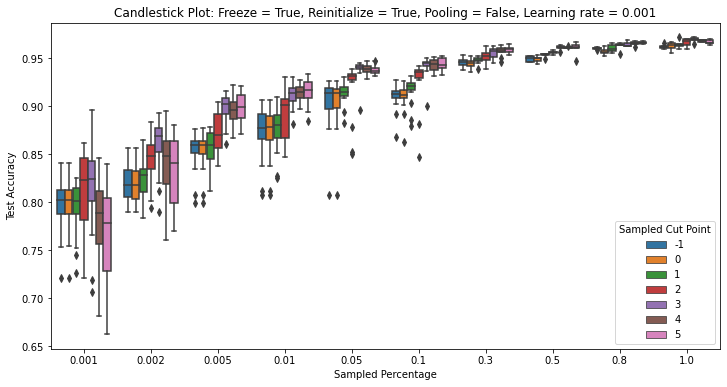

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining both datasets for comparative analysis
# df_combined = pd.DataFrame(results)
df_combined = pd.DataFrame(results_baseline+results)

# Creating boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='sampled_percentage', y='test_acc', hue='sampled_cut_point', data=df_combined)
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Sampled Percentage')
plt.ylabel('Test Accuracy')
plt.legend(title='Sampled Cut Point')
plt.show()

In [ ]:
#save results
with open(f'results_jsons/results_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run_MNIST.json', 'w') as f:
    json.dump(results, f)

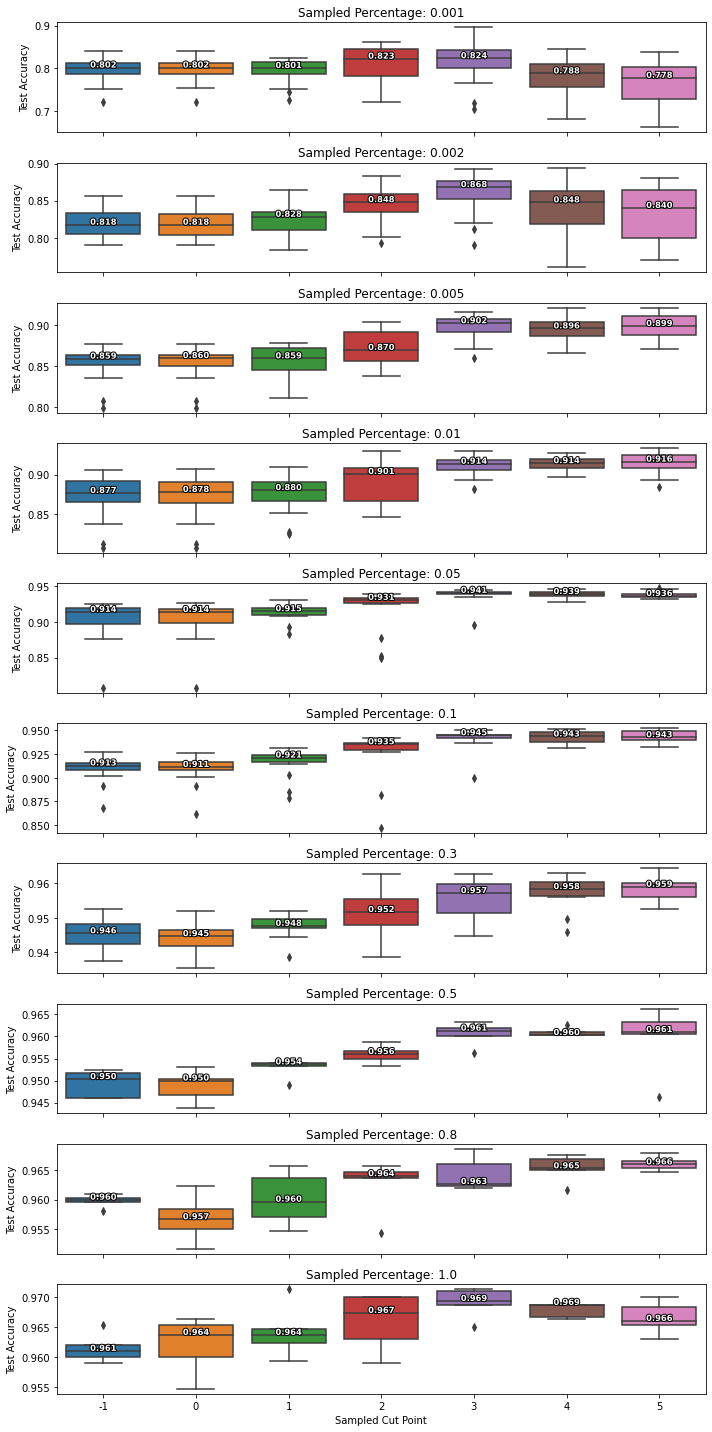

In [16]:
from matplotlib import patheffects

# Creating subplots for each data percentage



unique_percentages = df_combined['sampled_percentage'].unique()
#only 0.001 and 0.002
# unique_percentages = [0.001, 0.002]

n_percentages = len(unique_percentages)

# Adjusting the subplot layout for better readability of median values (improving contrast)
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 20), sharex=True)

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df_combined[df_combined['sampled_percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='sampled_cut_point', y='test_acc', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point')
    if i == n_percentages - 1:
        axes[i].set_xlabel('Sampled Cut Point')
    else:
        axes[i].set_xlabel('')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value and adjusting for better contrast
    medians = df_subset.groupby(['sampled_cut_point'])['test_acc'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

plt.tight_layout()
plt.show()


In [41]:
#print results for cut point = -1
results_baseline[:15]


[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 0,
  'train_acc': 1.0,
  'test_acc': 0.7899609133923061},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 1,
  'train_acc': 0.2,
  'test_acc': 0.20757045875334293},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 2,
  'train_acc': 1.0,
  'test_acc': 0.7656860728245217},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 3,
  'train_acc': 1.0,
  'test_acc': 0.7556058424192553},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 4,
  'train_acc': 1.0,
  'test_acc': 0.7368854145237606},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 5,
  'train_acc': 1.0,
  'test_acc': 0.7045875334293356},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 6,
  'train_acc': 1.0,
  'test_acc': 0.5918535280806418}

In [42]:
#results where cut point = 0
results_cut_0 = [result for result in results if result["sampled_cut_point"] == 0]
results_cut_0[:15]

[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 0,
  'train_acc': 1.0,
  'test_acc': 0.8043612425426867},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 1,
  'train_acc': 1.0,
  'test_acc': 0.7761777412055133},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 2,
  'train_acc': 0.96,
  'test_acc': 0.8372762806006995},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 3,
  'train_acc': 1.0,
  'test_acc': 0.7642460399094837},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 4,
  'train_acc': 1.0,
  'test_acc': 0.7486113968319276},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 5,
  'train_acc': 1.0,
  'test_acc': 0.7574573133100185},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 6,
  'train_acc': 1.0,
  'test_acc': 0.6418432421312487},
 {'lr

In [46]:
# Print or log the sampled values for transparency
sampled_percentage = 0.001
sampled_cut_point = 0
repeat = 0

print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

# Reduce the dataset
train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
torch.manual_seed(repeat)
#train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

# Copy and then cut the model - we already deepcopy it in the function: pretrained_model
#model_temp = copy.deepcopy(template_model)
model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

model_temp.to(device)

# Train and evaluate
trainer = Trainer(model_temp, dataset_namespace_new, params['lr_fine_tune'], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Store the results
print({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7900
{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7899609133923061}


In [71]:
torch.manual_seed(repeat)

model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

model_temp.to(device)


print(model_temp.conv0.weight[0][0][0])


tensor([-0.0015,  0.1073, -0.1646, -0.1472, -0.0770],
       grad_fn=<SelectBackward0>)


In [73]:
torch.manual_seed(2)


model_new = cut_custom_cnn_model(model_temp, cut_point=sampled_cut_point, params=params)

print(model_new.conv0.weight[0][0][0])


tensor([ 0.0459, -0.0476,  0.0548, -0.0102,  0.0854],
       grad_fn=<SelectBackward0>)


In [47]:
# Add the combination to the tested set
# tested_combinations.add((sampled_percentage, sampled_cut_point))

# Print or log the sampled values for transparency
print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

# Reduce the dataset
train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)

# Copy and then cut the model - we already deepcopy it in the function: pretrained_model
model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, params=params)

# Train and evaluate
trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Store the results
print({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8044
{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8043612425426867}


In [34]:
median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['sampled_cut_point'] == cut_point]['test_acc']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['sampled_percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['sampled_cut_point'] != -1]['sampled_cut_point'].unique():
        subset = df_differences[(df_differences['sampled_percentage'] == percentage) & (df_differences['sampled_cut_point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'sampled_percentage': percentage,
            'sampled_cut_point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


In [35]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

,sampled_percentage,sampled_cut_point,statistic,p_value,is_significant
0,0.001,0,89.0,0.570597,False
1,0.001,1,101.0,0.898317,False
2,0.001,2,28.0,0.002712,True
3,0.001,3,21.0,0.000851,True
4,0.002,0,86.0,0.498009,False
5,0.002,1,85.0,0.474905,False
6,0.002,2,23.0,0.001209,True
7,0.002,3,37.0,0.009436,True
